# Labeling school budget data

Goal: Perform NLP on school budget data to predict accurate labels for the expenditure category using multiclass classification models from scikit learn. 

We will build a human-in-the-loop system by assigning a probability of labels to each line item.  

Author: Sushant N. More

Data from [DrivenData](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/data/) 

Ref: Datacamp

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [7]:
df_train = pd.read_csv(r'C:\Users\KrishnaBalram\Desktop\School Budget\School Budget TrainingData.csv', index_col=0)

In [8]:
df_train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,...,Non-Certificated Salaries And Wages,NaN,NaN,Care and Upkeep of Building Services,NaN,NaN,-8291.86,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating,REPAIR AND MAINTENANCE SERVICES,...,NaN,ADMIN. SERVICES,NaN,STUDENT TRANSPORT SERVICE,NaN,NaN,618.29,PUPIL TRANSPORTATION,General Fund,NaN
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,49768.82,Instruction - Regular,General Purpose School,NaN
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,General Supplies,...,General Supplies,NaN,NaN,Instruction,Instruction And Curriculum,NaN,-1.02,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,NaN
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Other Community Services *,NaN,NaN,2304.43,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I PI+HOMELESS


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 198 to 101861
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Function                1560 non-null   object 
 1   Use                     1560 non-null   object 
 2   Sharing                 1560 non-null   object 
 3   Reporting               1560 non-null   object 
 4   Student_Type            1560 non-null   object 
 5   Position_Type           1560 non-null   object 
 6   Object_Type             1560 non-null   object 
 7   Pre_K                   1560 non-null   object 
 8   Operating_Status        1560 non-null   object 
 9   Object_Description      1461 non-null   object 
 10  Text_2                  382 non-null    object 
 11  SubFund_Description     1183 non-null   object 
 12  Job_Title_Description   1131 non-null   object 
 13  Text_3                  296 non-null    object 
 14  Text_4                  193 non-null

In [10]:
df_train.tail()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
344986,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,27.04000,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
384803,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,EMPLOYEE BENEFITS,...,NaN,PERSONNEL-PAID LEAVE,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,NaN,STAFF SERVICES,NaN,CENTRAL
224382,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,NO_LABEL,PreK-12 Operating,OTHER PERSONAL SERVICES,...,NaN,School,0.0,EXCEPTIONAL,NaN,NaN,200.39000,NaN,GENERAL FUND,NaN
305347,Facilities & Maintenance,O&M,Leadership & Management,Non-School,Gifted,Custodian,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Extra Duty Pay/Overtime For Support Personnel,...,Extra Duty Pay/Overtime For Support Personnel,Unallocated,NaN,Facilities Maintenance And Operations,Gifted And Talented,ANY CUS WHO IS NOT A SUPER,5.29000,Gifted And Talented,General Operating Fund,ADDL REGULAR PAY-NOT SMOOTHED
101861,Teacher Compensation,Instruction,School Reported,School,Poverty,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF REGULAR EMPLOYEES,...,NaN,NaN,NaN,TITLE I,NaN,PROFESSIONAL-INSTRUCTIONAL,1575.03504,GENERAL ELEMENTARY EDUCATION,NaN,REGULAR INSTRUCTION


In [11]:
df_train.columns

Index(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status',
       'Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'FTE', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Total',
       'Program_Description', 'Fund_Description', 'Text_1'],
      dtype='object')

In [12]:
df_train.describe()

,FTE,Total
count,449.000000,1.542000e+03
mean,0.493532,1.446867e+04
std,0.452844,7.916752e+04
min,-0.002369,-1.044084e+06
25%,0.004310,1.108111e+02
50%,0.440000,7.060299e+02
75%,1.000000,5.347760e+03
max,1.047222,1.367500e+06


FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

The variance in expenditure is high. Makes sense---some purchases are cheap, some are expensive. 

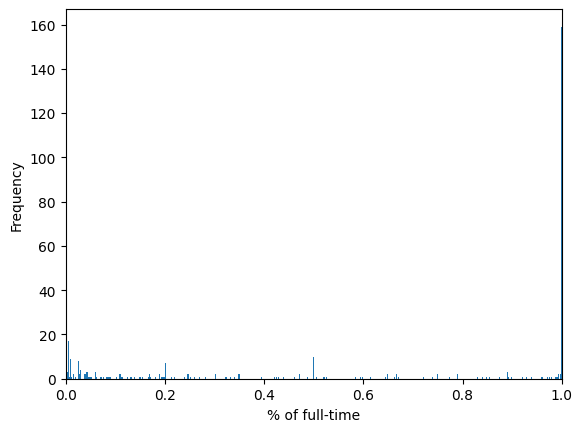

In [13]:
df_train['FTE'].dropna().plot(kind = 'hist', xlim = [0, 1], bins = 500);
plt.xlabel('% of full-time');

Bi-modal distribution! 

Making variables categorical.

First let's look at object variables. 

In [14]:
df_train.dtypes

Function                   object
Use                        object
Sharing                    object
Reporting                  object
Student_Type               object
Position_Type              object
Object_Type                object
Pre_K                      object
Operating_Status           object
Object_Description         object
Text_2                     object
SubFund_Description        object
Job_Title_Description      object
Text_3                     object
Text_4                     object
Sub_Object_Description     object
Location_Description       object
FTE                       float64
Function_Description       object
Facility_or_Department     object
Position_Extra             object
Total                     float64
Program_Description        object
Fund_Description           object
Text_1                     object
dtype: object

In [15]:
df_train.dtypes.value_counts()

object     23
float64     2
dtype: int64

The object types are slow and don't work well with ML algorithms.

For each of these rows, ERS attaches one label from each of 9 different categories as explained [here.](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#labels_list)

Next we convert these labels into categories type.

In [16]:
labels = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [17]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating


In [18]:
df_train[labels].shape

(1560, 9)

In [19]:
set(df_train.columns) - set(labels)

{'FTE',
 'Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4',
 'Total'}

In [20]:
categorize_label = lambda lab: lab.astype('category')

In [21]:
df_train[labels] = df_train[labels].apply(categorize_label, axis = 'rows')

In [22]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating


In [23]:
df_train[labels].dtypes

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object

In [24]:
df_train[labels].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 198 to 101861
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Function          1560 non-null   category
 1   Use               1560 non-null   category
 2   Sharing           1560 non-null   category
 3   Reporting         1560 non-null   category
 4   Student_Type      1560 non-null   category
 5   Position_Type     1560 non-null   category
 6   Object_Type       1560 non-null   category
 7   Pre_K             1560 non-null   category
 8   Operating_Status  1560 non-null   category
dtypes: category(9)
memory usage: 29.7 KB


Counting unique labels

In [25]:
df_train[labels].nunique()

Function            37
Use                  8
Sharing              5
Reporting            3
Student_Type         9
Position_Type       25
Object_Type         11
Pre_K                3
Operating_Status     3
dtype: int64

In [26]:
type(df_train[labels].nunique())

pandas.core.series.Series

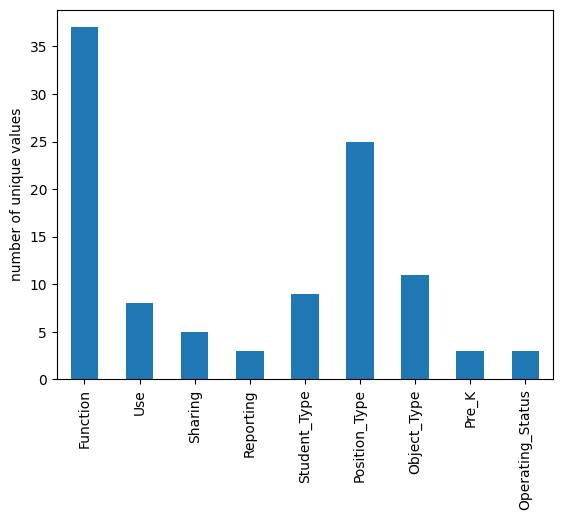

In [27]:
df_train[labels].nunique().plot(kind = 'bar');
plt.ylabel('number of unique values');

**Model building**

As a first pass build a simple model using just the numeric columns.

In [28]:
numeric_data = df_train.select_dtypes(include = [float]).fillna(-1000)
# filling NaNs with a large negative number

In [29]:
numeric_columns = list(df_train.select_dtypes(include = [float]).columns.values)

In [30]:
numeric_columns

['FTE', 'Total']

In [31]:
numeric_data.head()

,FTE,Total
198,-1000.0,-8291.86
209,-1000.0,618.29
750,1.0,49768.82
931,-1000.0,-1.02
1524,-1000.0,2304.43


In [32]:
numeric_columns

['FTE', 'Total']

In [33]:
df_train[numeric_columns].head()

,FTE,Total
198,NaN,-8291.86
209,NaN,618.29
750,1.0,49768.82
931,NaN,-1.02
1524,NaN,2304.43


In [34]:
df_label_dummies = pd.get_dummies(df_train[labels])

In [35]:
df_label_dummies.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [36]:
df_label_dummies.shape

(1560, 104)

In [37]:
df_train[labels].shape

(1560, 9)

** Doing the test-train split **

Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. A way to do this is using StratifiedShuffleSplit. However scikit-learn's StratifiedShuffleSplit works only for one target variable. Here we have 104 of them! 

To accomplish the stratified shuffle split for multiple target variable, I use the function written by [Peter Bull.](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py)

In [38]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

The function multilabel_train_test_split() makes sure that at least min_count examples appear in each split. 

In [39]:
from warnings import warn

In [40]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data,
                                                               df_label_dummies,
                                                               size=0.2, 
                                                               seed=123)

C:\Users\KrishnaBalram\AppData\Local\Temp\ipykernel_13912\1498689033.py:22: UserWarning: Size less than number of columns * min_count, returning 520 items instead of 312.0.
  warn(msg.format(y.shape[1] * min_count, size))


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 198 to 101861
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     1040 non-null   float64
 1   Total   1040 non-null   float64
dtypes: float64(2)
memory usage: 24.4 KB


In [42]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 209 to 448628
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     520 non-null    float64
 1   Total   520 non-null    float64
dtypes: float64(2)
memory usage: 12.2 KB


In [43]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 198 to 101861
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 113.8 KB


In [44]:
y_train.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1770,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [45]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 209 to 448628
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 56.9 KB


Training Model

In [46]:
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

OneVsRestClassifier treats each columns of y independently. Essentially, it fits a separate classifier for each of the columns. 

In [47]:
clf.score(X_test, y_test)

0.0

Pretty dismal score. But not very surprising given that we threw out most of our data. Let's go ahead and test the predictions on the holdout test data. Note that because we are developing 'human-in-the-loop' system, we wanna output the probabilities. 

In [51]:
holdout = pd.read_csv(r'C:\Users\KrishnaBalram\Desktop\School Budget\HoldoutData.csv', index_col=0)

In [52]:
holdout.head()

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
237,Personal Services - Teachers,Instruction - Regular,NaN,NaN,NaN,NaN,NaN,0.0,NaN,TIME CARD CERTIFIEDAddl,Alternative Schools Instruction,175.350000,NaN,NaN,General Purpose School,NaN
466,Extra Duty/Signing Bonus Pay,Basic Educational Services,NaN,NaN,NaN,General,School,NaN,Instruction,NaN,NaN,43424.905849,NaN,NaN,General Fund,NaN
784,OTHER PERSONAL SERVICES,NaN,NaN,SUB TEACHER ALL,NaN,NaN,STAFF DEV AND INSTR MEDIA,0.0,INST STAFF TRAINING SVCS,NaN,NaN,75.090000,NaN,NaN,GENERAL FUND,TEACHER TRAINING
1786,TERMINAL LEAVE VACATION,NaN,NaN,INSPECTOR & SERVICE TECHNICIAN,NaN,NaN,TRANSPORTATION,0.0,PUPIL TRANSPORTATION SERVICES,NaN,NaN,5274.805500,NaN,NaN,GENERAL FUND,TERMINAL LEAVE
2643,Extra Duty/Signing Bonus Pay,Undistributed,NaN,NaN,NaN,Principal & Asst. Principal Support,Educator Quality,NaN,Curriculum & Instructional Staff Development,NaN,NaN,44789.326495,NaN,NaN,General Fund,NaN


In [53]:
prediction = clf.predict_proba(holdout[numeric_columns].fillna(-1000))

In [54]:
prediction

array([[6.52295372e-02, 2.53472616e-02, 4.99263293e-01, ...,
        5.43836066e-08, 1.81559426e-02, 5.00535064e-01],
       [2.51118136e-02, 1.41085520e-02, 2.96272733e-03, ...,
        8.57576609e-02, 1.15521435e-02, 9.39766790e-01],
       [6.52405284e-02, 2.53447800e-02, 4.99683470e-01, ...,
        5.43901375e-08, 1.81516744e-02, 5.00229586e-01],
       ...,
       [6.13567633e-02, 2.62921281e-02, 3.50758717e-01, ...,
        5.12905522e-08, 1.98044753e-02, 6.10428299e-01],
       [2.70955803e-02, 1.35159788e-02, 6.11598123e-03, ...,
        8.99243298e-02, 1.04258999e-02, 9.01868695e-01],
       [6.20609767e-02, 2.61191514e-02, 3.77001390e-01, ...,
        5.17078418e-08, 1.94932302e-02, 5.90651897e-01]])

In [55]:
prediction.shape

(2000, 104)

In [56]:
holdout.shape

(2000, 16)

In [57]:
df_train.shape

(1560, 25)

Note 25 - 16 = 9. We have 9 taget variables (before applying the get_dummies).

Let's write predictions to a dataframe

In [58]:
prediction_df = pd.DataFrame(data = prediction, columns=pd.get_dummies(df_train[labels]).columns, \
                            index = holdout.index)

In [59]:
prediction_df.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
237,0.065230,0.025347,0.499263,0.013329,0.018965,0.009383,0.023369,0.013562,0.048954,0.006267,...,0.009385,0.499304,0.499444,0.006638,0.500027,0.499972,0.030563,5.438361e-08,0.018156,0.500535
466,0.025112,0.014109,0.002963,0.038501,0.014139,0.005702,0.037037,0.020637,0.043679,0.005695,...,0.025662,0.010424,0.071322,0.041397,0.776877,0.182703,0.038604,8.575766e-02,0.011552,0.939767
784,0.065241,0.025345,0.499683,0.013329,0.018963,0.009382,0.023371,0.013564,0.048954,0.006266,...,0.009384,0.499701,0.499761,0.006639,0.500012,0.499988,0.030567,5.439014e-08,0.018152,0.500230
1786,0.064673,0.025474,0.477906,0.013286,0.019067,0.009449,0.023285,0.013476,0.048966,0.006310,...,0.009451,0.479124,0.483298,0.006621,0.500813,0.499159,0.030361,5.405246e-08,0.018374,0.516067
2643,0.025052,0.014128,0.002896,0.038469,0.014159,0.005713,0.037001,0.020602,0.043682,0.005706,...,0.025709,0.010203,0.070186,0.041370,0.777023,0.182573,0.038537,8.562962e-02,0.011589,0.940701


Notice how we have probabilities for each column. 

In [60]:
df_train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,...,Non-Certificated Salaries And Wages,NaN,NaN,Care and Upkeep of Building Services,NaN,NaN,-8291.86,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating,REPAIR AND MAINTENANCE SERVICES,...,NaN,ADMIN. SERVICES,NaN,STUDENT TRANSPORT SERVICE,NaN,NaN,618.29,PUPIL TRANSPORTATION,General Fund,NaN
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,49768.82,Instruction - Regular,General Purpose School,NaN
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,General Supplies,...,General Supplies,NaN,NaN,Instruction,Instruction And Curriculum,NaN,-1.02,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,NaN
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Other Community Services *,NaN,NaN,2304.43,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I PI+HOMELESS


In [61]:
df_train['Position_Extra']

198                               NaN
209                               NaN
750                           TEACHER
931                               NaN
1524                              NaN
                     ...             
344986     PROFESSIONAL-INSTRUCTIONAL
384803     PROFESSIONAL-INSTRUCTIONAL
224382                            NaN
305347    ANY CUS WHO IS NOT A SUPER 
101861     PROFESSIONAL-INSTRUCTIONAL
Name: Position_Extra, Length: 1560, dtype: object

### Getting started on NLP

#### The first thing to do is create a bag of words

Let's start by creating bag of words for just one feature 'Position_Extra'. We split the token on alpha numerics. Before doing that we fill the NaNs with empy strings.

In [62]:
df_train['Position_Extra'].fillna('', inplace = True)

In [63]:
TOKEN_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [64]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [65]:
# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKEN_ALPHANUMERIC, stop_words='english', tokenizer=LemmaTokenizer())

In [66]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KrishnaBalram\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [67]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KrishnaBalram\AppData\Roaming\nltk_data...


True

In [68]:
vec_alphanumeric.fit(df_train['Position_Extra'])

C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


CountVectorizer(stop_words='english', token_pattern='[A-Za-z0-9]+(?=\\s+)',
                tokenizer=<__main__.LemmaTokenizer object at 0x000001EA7595EA70>)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [70]:
vec_alphanumeric.get_feature_names_out()

array(['&', '(', ')', ',', '-', '.', '1st', '2nd', '3rd', 'ab',
       'additional', 'addl', 'adm', 'administrative', 'administrator',
       'aide', 'allotment', 'art', 'assessment', 'asset', 'assistant',
       'asst', 'athletic', 'audiologist', 'avg', 'bachelor', 'bilingual',
       'board', 'building', 'bus', 'campbell', 'campus', 'card', 'career',
       'ccoach', 'cert', 'certified', 'certifiedaddl', 'charge',
       'classified', 'clerical', 'clerical/bookkeeper', 'clerk', 'clinic',
       'co-tchr', 'coach', 'computer', 'consultant', 'cont', 'contained',
       'contractual', 'counselor', 'craft', 'cu', 'custodian', 'data',
       'day', 'degreed', 'director', 'driver', 'ed', 'education', 'elem',
       'elem/inter', 'elem/interm', 'elementary', 'employee', 'engineer',
       'equip', 'executive', 'food', 'gifted', 'grade', 'gross',
       'guidance', 'h', 'head', 'high', 'i/ext', 'ii/ext', 'iii/ext',
       'instruc', 'instructional', 'interrelated', 'intervention', 'intr',
  

In [71]:
len(vec_alphanumeric.get_feature_names_out()) # vanilla version CountTokenizer()

170

In [72]:
len(vec_alphanumeric.get_feature_names_out()) # Using stop words

170

In [73]:
len(vec_alphanumeric.get_feature_names_out()) # Using LemmaTokenizer()

170

In [74]:
type(vec_alphanumeric.get_feature_names_out())

numpy.ndarray

In [75]:
LABELS = labels
NUMERIC_COLUMNS = numeric_columns

In order to get a bag-of-words representation for all of the text data in our DataFrame, we must first convert the text data in each row of the DataFrame into a single string.

We proceed to do so by grabbing all the data from columns which are not numeric or label data and then combine it into one string for each row to pass to the tokenizer. Note: above when we were looking at just one column 'Position_Extra', we automatically had one string per row. 
Now, we will create a bag of words for each row by joining the strings. 

We write a function for that.

In [76]:
LABELS

['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [77]:
df_train.columns.tolist()

['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status',
 'Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [78]:
to_drop = NUMERIC_COLUMNS + LABELS

In [79]:
set(to_drop)

{'FTE',
 'Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Total',
 'Use'}

In [80]:
set(to_drop) & set(df_train.columns.tolist())

{'FTE',
 'Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Total',
 'Use'}

In [81]:
def combine_text_columns(df, to_drop = NUMERIC_COLUMNS + LABELS):
    """converts all text in each row of data_frame df to a single vector"""
    
    #Drop non-text columns that are in df
    to_drop = set(to_drop) & set(df.columns.tolist())
    
    text_data = df.drop(to_drop, axis = 1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace = True)
    
    # Join all text items in a row that have a space in between
    
    return text_data.apply(lambda x: ' '.join(x), axis = 1)

Now you will use combine_text_columns() to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

We will use two ways of tokenizing. One using any non-whitespace characters as a token and other using only alphanumeric characters as token.

In [82]:
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [83]:
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

In [84]:
text_vector = combine_text_columns(df_train, to_drop = NUMERIC_COLUMNS + LABELS)

In [85]:
type(text_vector)

pandas.core.series.Series

In [86]:
text_vector.head()

198     Supplemental *  Operation and Maintenance of P...
209     REPAIR AND MAINTENANCE SERVICES  PUPIL TRANSPO...
750     Personal Services - Teachers   TCHER 5TH GRADE...
931     General Supplies      General Supplies  Instru...
1524    Supplies and Materials  Community Services    ...
dtype: object

In [87]:
df_train.shape

(1560, 25)

In [88]:
vec_basic.fit_transform(text_vector)
vec_alphanumeric.fit_transform(text_vector)

<1560x1117 sparse matrix of type '<class 'numpy.int64'>'
	with 21862 stored elements in Compressed Sparse Row format>

In [89]:
vec_basic.get_feature_names_out()

array(['"(year', '"guidance,', '"human', ..., 'yr', 'yrs', 'zuni'],
      dtype=object)

In [90]:
vec_alphanumeric.get_feature_names_out()

array(['00a', '12', '1st', ..., 'yrs', 'yth', 'zuni'], dtype=object)

In [91]:
df_train.iloc[1, :]

Function                           Student Transportation
Use                                              NO_LABEL
Sharing                                   Shared Services
Reporting                                      Non-School
Student_Type                                     NO_LABEL
Position_Type                                    NO_LABEL
Object_Type                        Other Non-Compensation
Pre_K                                            NO_LABEL
Operating_Status                        PreK-12 Operating
Object_Description        REPAIR AND MAINTENANCE SERVICES
Text_2                                                NaN
SubFund_Description                  PUPIL TRANSPORTATION
Job_Title_Description                                 NaN
Text_3                                                NaN
Text_4                                                NaN
Sub_Object_Description                                NaN
Location_Description                      ADMIN. SERVICES
FTE           

In [92]:
len(vec_basic.get_feature_names_out())

1404

In [93]:
len(vec_alphanumeric.get_feature_names_out())

1117

Tokenizing on alpha-numeric tokens reduces the number of token. 

### Let's build a pipeline

The Pipeline workflow is a 

* Repeatable way to go from raw data to trained model

* Pipieline object takes sequential list of steps

* Output of one step is input to next step

* Each step is a tuple with two elements -- the name which is a string, and an object that implements .fit() and .transform() methods

* Pipeline are a flexible way to represent the workflow. In fact, a step can itself be another pipeline. 

The problem here is that the text and numeric data don't work together. For instance, CountVectorizer doesn't know what to do with numeric data and Imputer doesn't know how to imput on text columns. 

Solution: buid two different pipelines using FunctionTransformer and put them together using FeatureUnion. 

In [94]:
NUMERIC_COLUMNS + LABELS

['FTE',
 'Total',
 'Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [95]:
ALL_COLUMNS = df_train.columns.tolist()

In [96]:
TEXT_COLUMNS = list(np.setdiff1d(ALL_COLUMNS, NUMERIC_COLUMNS + LABELS))

In [97]:
TEXT_COLUMNS

['Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

Note we need to use the combine_text_columns function because our tokenizer accepts one string.

In [98]:
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

FunctionTransformer job is to take a Python function and turn it into an object that a scikit-learn pipeline can understand.

The validate=False tells scikit-learn it doesn't need to check for NaNs or validate the dtypes of the input. We will do that work outselves.

In [99]:
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate = False)

In [100]:
get_numeric_data

FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)

In [101]:
df_train[TEXT_COLUMNS].head()

,Facility_or_Department,Function_Description,Fund_Description,Job_Title_Description,Location_Description,Object_Description,Position_Extra,Program_Description,SubFund_Description,Sub_Object_Description,Text_1,Text_2,Text_3,Text_4
198,NaN,Care and Upkeep of Building Services,Title I - Disadvantaged Children/Targeted Assi...,NaN,NaN,Supplemental *,,NaN,Operation and Maintenance of Plant Services,Non-Certificated Salaries And Wages,TITLE I CARRYOVER,NaN,NaN,NaN
209,NaN,STUDENT TRANSPORT SERVICE,General Fund,NaN,ADMIN. SERVICES,REPAIR AND MAINTENANCE SERVICES,,PUPIL TRANSPORTATION,PUPIL TRANSPORTATION,NaN,NaN,NaN,NaN,NaN
750,NaN,NaN,General Purpose School,TCHER 5TH GRADE,NaN,Personal Services - Teachers,TEACHER,Instruction - Regular,NaN,NaN,NaN,NaN,NaN,Regular Instruction
931,Instruction And Curriculum,Instruction,General Operating Fund,NaN,NaN,General Supplies,,"""Title I, Part A Schoolwide Activities Related...",NaN,General Supplies,NaN,NaN,NaN,NaN
1524,NaN,Other Community Services *,Title I - Disadvantaged Children/Targeted Assi...,NaN,NaN,Supplies and Materials,,NaN,Community Services,Supplies And Materials,TITLE I PI+HOMELESS,NaN,NaN,NaN


In [102]:
just_text_data = get_text_data.fit_transform(df_train)

In [103]:
just_text_data.head()

198     Supplemental *  Operation and Maintenance of P...
209     REPAIR AND MAINTENANCE SERVICES  PUPIL TRANSPO...
750     Personal Services - Teachers   TCHER 5TH GRADE...
931     General Supplies      General Supplies  Instru...
1524    Supplies and Materials  Community Services    ...
dtype: object

In [104]:
just_text_data.shape

(1560,)

In [105]:
len(TEXT_COLUMNS)

14

In [106]:
just_numeric_data = get_numeric_data.fit_transform(df_train)

In [107]:
just_numeric_data.shape

(1560, 2)

### Using FeatureUnion()

We combine the multiple type of feature processing using the FeatureUnion utility for scikit-learn.

Before that we use the multilabel_train_test_split() we defined above on all of the data set.

In [108]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df_train[NUMERIC_COLUMNS + TEXT_COLUMNS],
                                                               pd.get_dummies(df_train[LABELS]),
                                                               size=0.2, 
                                                               seed=123)

C:\Users\KrishnaBalram\AppData\Local\Temp\ipykernel_13912\1498689033.py:22: UserWarning: Size less than number of columns * min_count, returning 520 items instead of 312.0.
  warn(msg.format(y.shape[1] * min_count, size))


** Create a FeatureUnion with nested pipeline **

In [109]:
from sklearn.impute import SimpleImputer

In [110]:
process_and_join_features = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', SimpleImputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer())
                                ]))
                            ])

In [111]:
process_and_join_features_alphanum = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', SimpleImputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC, ngram_range=(1, 2)))
                                ]))
                            ])

In [112]:
process_and_join_features_basic = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', SimpleImputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_BASIC))
                                ]))
                            ])

In [113]:
pl = Pipeline([
    ('union', process_and_join_features),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [114]:
pl_alphanum = Pipeline([
    ('union', process_and_join_features_alphanum),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [115]:
pl_basic = Pipeline([
    ('union', process_and_join_features_basic),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [116]:
X_train.head()

,FTE,Total,Facility_or_Department,Function_Description,Fund_Description,Job_Title_Description,Location_Description,Object_Description,Position_Extra,Program_Description,SubFund_Description,Sub_Object_Description,Text_1,Text_2,Text_3,Text_4
198,NaN,-8291.86,NaN,Care and Upkeep of Building Services,Title I - Disadvantaged Children/Targeted Assi...,NaN,NaN,Supplemental *,,NaN,Operation and Maintenance of Plant Services,Non-Certificated Salaries And Wages,TITLE I CARRYOVER,NaN,NaN,NaN
750,1.0,49768.82,NaN,NaN,General Purpose School,TCHER 5TH GRADE,NaN,Personal Services - Teachers,TEACHER,Instruction - Regular,NaN,NaN,NaN,NaN,NaN,Regular Instruction
1524,NaN,2304.43,NaN,Other Community Services *,Title I - Disadvantaged Children/Targeted Assi...,NaN,NaN,Supplies and Materials,,NaN,Community Services,Supplies And Materials,TITLE I PI+HOMELESS,NaN,NaN,NaN
1770,NaN,1505.85,NaN,BASIC (FEFP K-12),GENERAL FUND,COACHING SUPPLEMENT PAY,School,ATHLETIC SUPPLEMENTS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,NaN,2400.59,NaN,INST STAFF TRAINING SVCS,GENERAL FUND,NaN,School,CONFERENCE REGISTRATION,,NaN,NaN,NaN,SCHOOL OPERATING ACCOUNT,NaN,NaN,NaN


In [117]:
y_train.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1770,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [118]:
pl.fit(X_train, y_train)

C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_columns at 0x000001EA75B70820>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer())]))])),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [119]:
pl.score(X_test, y_test)

0.0

In [120]:
pl_alphanum.fit(X_train, y_train)

C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_columns at 0x000001EA75B70820>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               2),
                                                                                  token_pattern='[A-Za-z0-9]+(?=\\s+)'))]))])),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [121]:
pl_alphanum.score(X_test, y_test)

0.0

In [122]:
pl_basic.fit(X_train, y_train)

C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KrishnaBalram\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_columns at 0x000001EA75B70820>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(token_pattern='\\S+(?=\\s+)'))]))])),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [123]:
pl_basic.score(X_test, y_test)

0.0

When no parameter is passed to CountVectorizer, it uses the default value: From sklearn documentation:  The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)

Let's test another model. See how using pipeline makes it all very nifty.

In [124]:
plRF = Pipeline([
    ('union', process_and_join_features),
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [125]:
plRF.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_columns at 0x000001EA75B70820>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer())]))])),
                ('clf',
                 OneVsRestClassifier(estimator=RandomForestClassifier()))])

In [126]:
plRF.score(X_test, y_test)

0.36923076923076925

Wow! Huge improvement on the score.

Evidently RandomForestClassifier() works with multiclass labels out of the box. 

** Using n-grams and MaxAbsScaler **

In [127]:
from sklearn.preprocessing import MaxAbsScaler

In [128]:
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer',SimpleImputer())
                ])),

                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2)))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

In [129]:
pl.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001EA75980280>)),
                                                                 ('imputer',
                                                                  SimpleImputer())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function combine_text_columns at 0x000001EA75B70820>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               2),
                                                                                  token_pattern='[A-Za-z0-9]+(?=\\s+)'))]))])),
                ('scale', MaxAbsScaler()),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [130]:
pl.score(X_test, y_test)

0.3596153846153846

SparseInteractions code from https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py

SparseInteractions does the same thing as sklearn.preprocessing.PolynomialFeatures, but it uses sparse matrices to do so.

In [131]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

Implementing the interaction model

In [133]:
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2)))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

Using HashingVectorizer to speed things up

In [134]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)

In [135]:
hashed_text

<1040x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 14986 stored elements in Compressed Sparse Row format>

In [136]:
hashed_text.data

array([-0.16012815,  0.16012815, -0.48038446, ..., -0.19611614,
        0.58834841, -0.19611614])

In [137]:
hashed_df.head()

,0
0,-0.160128
1,0.160128
2,-0.480384
3,-0.320256
4,0.160128


In [138]:
text_data.head()

198      Care and Upkeep of Building Services Title I ...
750       General Purpose School TCHER 5TH GRADE  Pers...
1524     Other Community Services * Title I - Disadvan...
1770     BASIC (FEFP K-12)              GENERAL FUND  ...
1951     INST STAFF TRAINING SVCS       GENERAL FUND  ...
dtype: object